In [5]:
include("replicas.jl")
include("data.jl")
using Plots, NLsolve#added from git

In [25]:
function RSB1_SP_fixParisi(β, h, m1; 
    init_m = 0.9,
    init_q0 = 0.2,
    init_q1 = 0.5,
    damping = 0.5, maxsteps = 2000, 
    tol = 1e-8, verbose = false, verboseStep = 10)

    x = [init_m, init_q0, init_q1]
    xerror = 200.
    rerror = 200.
    for i in 1:maxsteps

        updates = RSB1_updates(β, h, x..., m1)

        xnew = [0., 0., 0.]
        xnew[1] = damping * x[1] + (1-damping) * updates[1]
        xnew[2] = damping * x[2] + (1-damping) * updates[2]
        xnew[3] = damping * x[3] + (1-damping) * updates[3]

        xerror = norm(xnew .- x)
        rerror = RSB1_residuals(β, h, xnew..., m1)[1:3] |> norm

        if verbose && i % verboseStep == 0
            println([h, x..., m1, [xerror, rerror], i])
        end

        if max(xerror, rerror) < tol
            return (h, x..., m1, [xerror, rerror], 1., i)
        end

        x = xnew
    end
    (h, x..., m1, [xerror, rerror], 0., maxsteps)
end

RSB1_SP_fixParisi (generic function with 1 method)

In [26]:
function RSB1_SP_fixM_fixParisi(β, m_target, m1; 
    init_q0 = 0.2,
    init_q1 = 0.5,
    init_h = 0.,
    damping = 0.5, maxsteps = 2000, 
    tol = 1e-8, verbose = false, verboseStep = 10,
    hupdatestep = 1, hdamping = 0.5, hskip = true
    )

    x = [m_target, init_q0, init_q1, init_h]
    xerror = 200.
    rerror = 200.
    merror = 200.

    for i in 1:maxsteps

        updates = RSB1_updates(β, x[4], m_target, x[2], x[3], m1)

        xnew = [0., 0., 0., 0.]
        xnew[1] = damping * x[1] + (1-damping) * updates[1]
        xnew[2] = damping * x[2] + (1-damping) * updates[2]
        xnew[3] = damping * x[3] + (1-damping) * updates[3]

        uph =   try
                    i % hupdatestep == 0 ? 
                        find_zero(h -> RSB1_eqH(β, h, m_target, xnew[2], xnew[3], m1), x[4]) : 
                        x[4]
                catch
                    verbose ? println("Failed in solving equation for h at iteration ", i) : Nothing
                    if hskip
                        up = x[4] + 0.1 * (rand()-0.5)
                        up
                    else
                        return (x[4], m_target, x[2:3]..., m1, [xerror, rerror, merror], 0., i)
                    end
                end

        xnew[4] = hdamping * x[4] + (1-hdamping) * uph

        xerror = norm(xnew .- x)
        merror = abs(m_target - x[1])
        rerror = RSB1_residuals(β, xnew[4]..., m_target, xnew[2], xnew[3], m1)[1:3] |> norm

        if verbose && i % verboseStep == 0
            println([xnew[4], m_target, xnew[2:3]..., m1, [xerror, rerror, merror], i])
        end

        if max(xerror, merror, rerror) < tol
            return (xnew[4], m_target, xnew[2:3]..., m1, [xerror, rerror, merror], 1., i)
        end

        x = xnew
    end
    (x[4], m_target, x[2:3]..., m1, [xerror, rerror, merror], 0., maxsteps)
end

RSB1_SP_fixM_fixParisi (generic function with 1 method)

In [55]:
function complexity(beta, m; 
    tol = 1e-10, damping = 0.1, hupdatestep = 1, hdamping = 0.1, verbose = false, 
    init_q0 = 0.1, init_q1 = 0.9, init_h = 0., maxsteps = 500, m1 = 0.99)

    res = RSB1_SP_fixM_fixParisi(
        beta, m, m1, 
        init_h = init_h, init_q0 = init_q0, init_q1 = init_q1,
        damping = damping, tol = tol, hupdatestep = hupdatestep, hdamping = hdamping, verbose = verbose) 

    params = [beta, res[1], m, res[3], res[4], 1.]
    eqm1 = RSB1_eqM1(params...)
    fstar = RSB1_freeEntropy(params...) + eqm1
    sigma = - eqm1
    (fstar, sigma, res)
end

complexity (generic function with 1 method)

In [68]:
complexity(28., 0.02, tol = 1e-6)

(-0.05831141344696467, 0.0005762209339854399, (-0.4180860037247185, 0.02, 0.0006269828104903909, 0.009985250241274161, 0.99, [9.341716371383562e-7, 9.779797485145713e-7, 5.4827653563072065e-9], 1.0, 84))

In [93]:
function complexity_solver(beta, m; uptol = 1e-8,
    rtol = 1e-5, xtol = 1e-10, init_h = 0., init_q0 = 1.01 * m^2, init_q1 = 0.99 * m, verbose = false, m1 = 1.)

    initial_residuals = RSB1_updates(beta, init_h, m, init_q0, init_q1, m1, tol = uptol) - [m, init_q0, init_q1]

    ftol = min(xtol, rtol * norm(initial_residuals))

    function f!(F, x)
        h, q0, q1 = x
        F[1], F[2], F[3] = RSB1_updates(beta, h, m, q0, q1, m1, tol = uptol) - [m, q0, q1]
    end

    solver = mcpsolve(f!, [-Inf, m^2, m^2], [+Inf, m, m], [init_h, init_q0, init_q1], xtol = xtol, ftol = ftol, show_trace = verbose, extended_trace = verbose)
    eqm1 = RSB1_eqM1(beta, solver.zero[1], m, solver.zero[2], solver.zero[3], 1., tol = uptol)
    

    eqm1, solver
end

complexity_solver (generic function with 1 method)

In [96]:
complexity_solver(28., 0.02, rtol = 1e-10, xtol = 1e-5, m1 = 0.99)

(-0.0022142569275874317, Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.000404, 0.0198]
 * Zero: [-0.41718173548540877, 0.000399993509164014, 0.02]
 * Inf-norm of residuals: 0.000000
 * Iterations: 38
 * Convergence: true
   * |x - x'| < 1.0e-05: true
   * |f(x)| < 1.7e-10: false
 * Function Calls (f): 38
 * Jacobian Calls (df/dx): 14)

In [85]:
RSB1_residuals(28., -0.4171, 0.02, 0.0006, 0.0099, 1.)

4-element Vector{Float64}:
 0.0008158617113600448
 6.869497950266648e-5
 0.0005759794179719807
 0.000150754902062053

---

In [12]:
ms, bs = hcat(sort(readdlm("data_RSstability_beta_crit.csv", '|', header = true)[1] |> myeachrow, by = first, rev = true)...) |> myeachrow

2-element Vector{Vector{Float64}}:
 [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9  …  0.0001, 9.0e-5, 8.0e-5, 7.0e-5, 6.0e-5, 5.0e-5, 4.0e-5, 3.0e-5, 2.0e-5, 1.0e-5]
 [450.060658066837, 120.07026391734883, 86.86214497994699, 68.2308505590221, 56.7092723177808, 48.83507209384861, 43.08994317715906, 38.70016299477827, 35.22868801505515, 32.4094523208558  …  945.348444890645, 1003.9172262749337, 1073.5653711644864, 1158.2116121899555, 1264.0155175188256, 1401.3373865307285, 1589.2919224985171, 1868.234248810775, 2344.1189418336326, 3446.6155869670624]

In [13]:
c 3 omplexity(0.99, 450.06)

---

## Complexity

In [5]:
datacomplexity = "data_complexity.csv"

"data_complexity.csv"

In [6]:
# header = "Type|Beta|Complexity|hCRSB1/hTarget|mCRSB1/mTarget|q0CRSB1|q1CRSB1|errorsRSB1|hRS/hTarget|mRS/mTarget|qRS|errorsRS"
# appendData(datacomplexity, header)

In [7]:
function complexityComputation(beta, m, init, tol)
    comp = complexity(beta, m, tol = tol, init_h = init[1], init_q0 = init[2], init_q1 = init[3])
    rsb1c = comp[3]
    c = comp[2]
    rs = RS_SP_fixM(beta, m)
    result = [ "C", beta, c, rsb1c[1:4]..., rsb1c[6], rs[1:4]...]
    result
end

complexityComputation (generic function with 1 method)

In [94]:
m = 0.95
complexityComputation(40., m, [-0.05,1.3e-8,m * 0.99], 1e-6)

12-element Vector{Any}:
   "C"
 40.0
  4.866933522862382e-10
  1.5497831097222599
  0.95
  0.9473538077891281
  0.9473558437046773
   [7.367084498526259e-7, 6.014364577615962e-7, 7.547509284222542e-10]
  1.5497831148736645
  0.95
  0.947353807934261
   [6.095526229111935e-11, 3.2807090377673376e-13, 4.4997339188057595e-13]

In [91]:
init = [-0.04535039999987845,1.003618846673002e-8,8.557974994238497e-5]
bs = linspace(599.5, 550., 60)
m = 0.0001

0.0001

In [92]:
for b in bs
    println(b); flush(stdout);
    res = complexityComputation(b, m, init, 1e-10)
    init = res[[4, 6, 7]]
    appendData(datacomplexity, res)
end

599.5


598.6610169491526


597.8220338983051


596.9830508474577


596.1440677966102


595.3050847457627


594.4661016949152


593.6271186440678


592.7881355932203


591.9491525423729


591.1101694915254


590.271186440678


589.4322033898305


588.5932203389831


587.7542372881356


586.9152542372881


586.0762711864406


585.2372881355932


584.3983050847457


583.5593220338983


582.7203389830509


581.8813559322034


581.042372881356


580.2033898305085


579.3644067796611


578.5254237288135


577.6864406779661


576.8474576271186


576.0084745762712


575.1694915254237


574.3305084745763


573.4915254237288


572.6525423728814


571.8135593220339


570.9745762711865


570.1355932203389


569.2966101694915


568.457627118644


567.6186440677966


566.7796610169491


565.9406779661017


565.1016949152543


564.2627118644068


563.4237288135594


562.5847457627119


561.7457627118644


560.9067796610169


560.0677966101695


559.228813559322


558.3898305084746


557.5508474576271


556.7118644067797


555.8728813559322


555.0338983050848


554.1949152542373


553.3559322033898


552.5169491525423


551.6779661016949


550.8389830508474


550.0


# Plot from file

In [216]:
function plot_complexity_h(datafile, m0)
    data, _ = readDataComplexity(datafile)

    ms = getindex.(data, 5)
    m = findnearest(ms, m0)
    dataFiltered = filter(x -> x[1] == "C" && abs(x[5] - m) < 1e-4 , data)

    if length(dataFiltered) == 0
        error("m = ", m, " not found in M data")
    end
    
    ws = sort(dataFiltered, by = x -> x[2])
    bs = getindex.(ws, 2)

    cs = getindex.(ws, 3)


    hs  = getindex.(ws, 4)
    q0s = getindex.(ws, 6)
    q1s = getindex.(ws, 7)
    
    hsRS = getindex.(ws, 9)
    qsRS = getindex.(ws, 11)

    p = plot(legend = :bottomleft, xlabel = "β", ylabel = "order parameters", 
        title = string("\nComplexity at m1 = 1 for m = ", m), 
            yscale = :log10,
            xlim = (min(bs...), max(bs...)),
            ylim = (0.9*m^2, 1.1*m), 
            size = (800, 500), 
            right_margin = 15Plots.mm, left_margin = 5Plots.mm, 
            bottom_margin = 5Plots.mm, top_margin = 7Plots.mm)

    plot!(twinx(p), bs, cs, ylim = :auto, label = "complexity", ylabel = "complexity", 
        legend = :topleft, color = :black,
        xlim = (min(bs...), max(bs...)), 
        grid = true
    ) 
    # hline!(twinx(p), [0.])

    # # plot!(p, bs, msRS, label = "m RS")
    plot!(p, bs, qsRS, label = "q RS")

    # # plot!(p, bs, hs, label = "h")
    plot!(p, bs, q0s, label = "q0")
    plot!(p, bs, q1s, label = "q1")

    vline!([44.3])
    p
end

plot_complexity_h (generic function with 1 method)

In [ ]:
p = plot_complexity_h(datacomplexity, 0.05)

In [197]:
savefig(p, "plots/complexity_m0.01.pdf")

## OLD

In [157]:
complexity(50., 0.01, tol = 1e-10, verbose = false, init_h = init[1], init_q0 = init[2], init_q1 = init[3])

InterruptException: InterruptException:

In [113]:
init = [-0.67, 0.01, 0.1]
res = []
m = 0.1

0.1

In [133]:
for b in linspace(11.9, 10., 20)
    comp = complexity(b, m, tol = 1e-10, verbose = false, init_h = init[1], init_q0 = init[2], init_q1 = init[3])
    init = [comp[3]...]
    println(b, "|", init[2], "|", init[3], "|", comp[end])
    push!(res, [b, comp[2]])
end

11.9|0.043232072346633926|0.06267601302243127|(-0.6656328417920019, 0.043232072346633926, 0.06267601302243127, 1.0)
11.8|0.042712462187216145|0.06164411443227327|(-0.6654610130796703, 0.042712462187216145, 0.06164411443227327, 1.0)
11.7|0.042185872541696076|0.06056869793815413|(-0.6652819904876641, 0.042185872541696076, 0.06056869793815413, 1.0)
11.6|0.04165233184205587|0.05944671907368884|(-0.665095373292818, 0.04165233184205587, 0.05944671907368884, 1.0)
11.5|0.04111188731454162|0.05827477394972058|(-0.6649007416264449, 0.04111188731454162, 0.05827477394972058, 1.0)
11.4|0.04056460715161207|0.057049032730289925|(-0.6646976566178008, 0.04056460715161207, 0.057049032730289925, 1.0)
11.3|0.0400105828267544|0.055765154799816974|(-0.664485660880044, 0.0400105828267544, 0.055765154799816974, 1.0)
11.2|0.03944993159584188|0.0544181791317769|(-0.6642642793087824, 0.03944993159584188, 0.0544181791317769, 1.0)
11.1|0.038882799150779745|0.05300238123894378|(-0.6640330203405163, 0.03888279915077

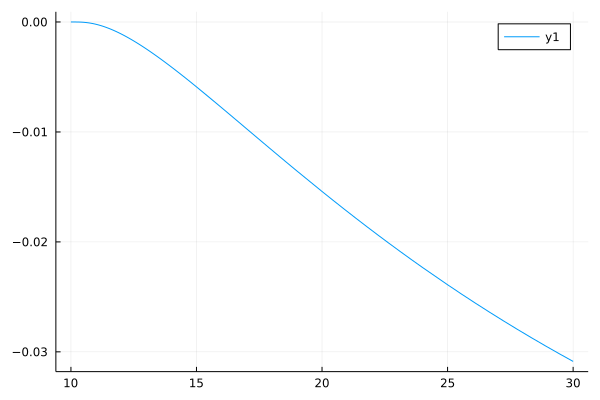

In [136]:
plot(getindex.(res, 1), getindex.(res, 2))

In [137]:
res

90-element Vector{Any}:
 [30.0, -0.03087235124051324]
 [29.444444444444443, -0.03016814806538426]
 [28.88888888888889, -0.029447110439158874]
 [28.333333333333332, -0.028708869814664473]
 [27.77777777777778, -0.02795306928273278]
 [27.22222222222222, -0.027179367945448507]
 [26.666666666666668, -0.02638744659797454]
 [26.11111111111111, -0.02557701232311904]
 [25.555555555555557, -0.024747807677402978]
 [25.0, -0.02389961712516131]
 ⋮
 [10.8, -0.00011289414035034473]
 [10.7, -7.633600900527893e-5]
 [10.6, -4.739135535450356e-5]
 [10.5, -2.5905509984602837e-5]
 [10.4, -1.1490930255014797e-5]
 [10.3, -3.403169473115142e-6]
 [10.2, -3.2951302722517006e-7]
 [10.1, 1.431965657161527e-12]
 [10.0, -1.028066520802895e-13]

## AAAA

In [27]:
RSB1_SP_fixM(1., 0.1, init_h = -0.55, init_q0 = 0.001, init_q1 = 0.01)

(-2.246212740267824, 0.1, 0.010081777054766618, 0.010081777060519683, 0.0013581062953632625, [3.286643870616116e-9, 9.416436947936694e-10, 6.008329750395447e-9], 1.0, 31)

In [19]:
complexity(15., 0.4, verbose = false, init_h = -0.5, init_q0 = 0.1, init_q1 = 0.9)

(0.8149717096923914, -0.005554009918113945, (-0.4711776892592392, 0.3577860224280491, 0.3824879481015493, 1.0))

In [109]:
bs = linspace(22.25, 30., 20)
res = vcat(map(beta->(beta, complexity(beta, 0.1, init_h = -0.55, init_q0 = 0.001, init_q1 = 0.01)[1:2]...), bs), res)

100-element Vector{Tuple{Float64, Float64, Float64}}:
 (22.25, -0.2832277171705712, 0.01941142220946407)
 (22.657894736842106, -0.28826821223926546, 0.020106661944207405)
 (23.06578947368421, -0.2932907148434699, 0.020789679523831706)
 (23.473684210526315, -0.2983093861946873, 0.021475637897314936)
 (23.88157894736842, -0.3033085022046297, 0.022128847104536997)
 (24.289473684210527, -0.30830726655490914, 0.022793544050163872)
 (24.69736842105263, -0.31328914898642723, 0.023423119257540037)
 (25.105263157894736, -0.3182749459289521, 0.02406768812668897)
 (25.513157894736842, -0.32324469234714215, 0.02467640764639295)
 (25.92105263157895, -0.3282155772909112, 0.02528844573429978)
 ⋮
 (20.166666666666668, -0.25721892256110396, 0.015711919699472998)
 (20.285714285714285, -0.2587345214864152, 0.015937350791699112)
 (20.714285714285715, -0.2641195857928469, 0.01671574790358671)
 (20.77777777777778, -0.26491440827392293, 0.016824997959917043)
 (21.142857142857142, -0.2694803117467602, 0.01748

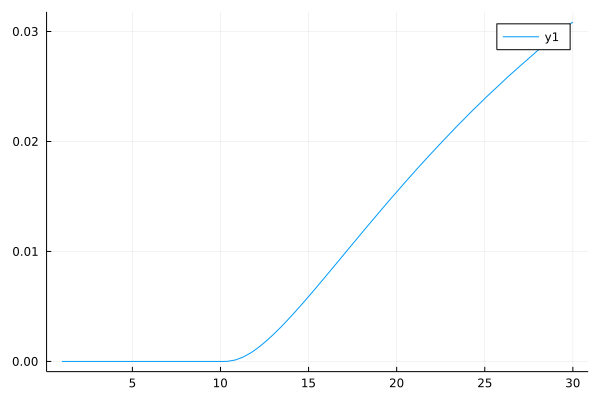

In [126]:
sort!(res, by = first)
fs = getindex.(res, 1)
cs = getindex.(res, 3)
plot(fs, (cs), yscale = :identity)

In [7]:
res

UndefVarError: UndefVarError: res not defined